# AirBnb Listings Data Analysis for Seattle Area

 We have taken our datasets from 'Inside Airbnb' which is an independent, non-commercial set of tools and data that allows us to explore how airbnb is really being used in cities around the world. We haven two datasets 'reviews.csv' and 'listings.csv' and we are merging both of them using the primary key 'listing_id'. We will be using the data in these datasets for our analysis.

In [480]:
#Import necessary libraries
import pandas as pd
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn import metrics
%matplotlib inline


In [481]:
# Read listing.csv and reviews.csv into dataframes and parse dates columns to datetime format
listings = pd.read_csv('listings (1).csv',parse_dates=['last_review'])
reviews = pd.read_csv('reviews (1).csv',parse_dates=['date'])

In [482]:
#Remove unwanted columns
listings.drop(['name','host_id','host_name','latitude','longitude','neighbourhood'
            ,'minimum_nights','calculated_host_listings_count','reviews_per_month','number_of_reviews']
            ,inplace=True, axis=1)

In [483]:
#data cleaning 
listings['neighbourhood_group'] = listings['neighbourhood_group'].str.strip()
listings['room_type'] = listings['room_type'].str.strip()

#Remove records where price = 0
listings = listings[listings.price != 0]
#have to impute other null values

#Remove outliers: for each neighborhood and each room type, remove listings with prices outside of 2 standard deviations
#Visualizing statistics
pd.options.display.float_format = '{:,.2f}'.format
listings_stats = listings.groupby(['neighbourhood_group','room_type']).price.agg(['min','max','mean', 'median','std'])
listings_stats = listings_stats.fillna(0)
listings_stats['min_price'] = listings_stats['mean'] - 0.75*listings_stats['std']
listings_stats['max_price'] = listings_stats['mean'] + 0.75*listings_stats['std']
#drop listings outside 2 standard deviations
listings = pd.merge(listings, listings_stats, how='left', on=['neighbourhood_group','room_type'])
listings = listings.drop(listings[(listings.price < listings.loc[:,'min_price'])].index) 
listings = listings.drop(listings[(listings.price > listings.loc[:,'max_price'])].index) 
listings.drop(['min','max','mean', 'median','std','min_price','max_price']
            ,inplace=True, axis=1)  
print(listings)
print(listings_stats)

#Remove records with last_review prior to 2017
listings = listings[listings.last_review >= '2017-01-01']
reviews = reviews[reviews.date >= '2017-01-01']

            id  neighbourhood_group        room_type  price last_review  \
0         2318         Central Area  Entire home/apt    296  2018-06-25   
1         4291  Other neighborhoods     Private room     82  2018-08-29   
3         6606  Other neighborhoods  Entire home/apt     90  2018-08-25   
4         9419  Other neighborhoods     Private room     65  2018-08-27   
5         9460             Downtown     Private room     80  2018-08-28   
6         9531         West Seattle  Entire home/apt    165  2018-09-04   
7         9534         West Seattle  Entire home/apt    125  2018-09-03   
8         9596  Other neighborhoods  Entire home/apt    120  2018-08-26   
9         9909         West Seattle  Entire home/apt    125  2018-08-27   
10       10209             Delridge     Private room     50  2018-06-20   
11       10385            Northgate     Private room     60  2018-08-20   
12       10695            Northgate     Private room    109  2018-09-04   
14       11411           

In [484]:
#make copies of reviews for diff groupby
reviews_2 = reviews.copy()
reviews_3 = reviews.copy()

#find number_of_reviews, initial_review and last_review, and merge them to one table
reviews = reviews.groupby('listing_id')['date'].size().reset_index(name='number_of_reviews')

reviews_2 = reviews_2.sort_values(by=['date']).drop_duplicates(subset='listing_id', keep='first')
reviews_2.rename(columns={'date': 'initial_review'}, inplace=True)
reviews = pd.merge(reviews, reviews_2, how='inner', on='listing_id')

reviews_3 = reviews_3.sort_values(by=['date']).drop_duplicates(subset='listing_id', keep='last')
reviews_3.rename(columns={'date': 'last_review'}, inplace=True)
updated_reviews = pd.merge(reviews, reviews_3, how='inner', on='listing_id')

#fill in a new column called avg_reviews_per_month
pd.options.display.float_format = '{:,.1f}'.format
updated_reviews = updated_reviews.assign(avg_reviews_per_month=reviews['number_of_reviews']/(12 *
                    (updated_reviews['last_review'].map(lambda x: x.year) -
                     updated_reviews['initial_review'].map(lambda x: x.year)) +
                    (updated_reviews['last_review'].map(lambda x: x.month) -
                     updated_reviews['initial_review'].map(lambda x: x.month))+1))

#we can merge the table if we want
listings = listings.rename(columns={"id": "listing_id"})
updated_listings = pd.merge(listings, updated_reviews, how='left', on=['listing_id','last_review'])
# print(updated_listings)


In [485]:
for col in updated_listings:
    if(updated_listings[col].isnull().any()):
        print(col)

number_of_reviews
initial_review
avg_reviews_per_month


Now that the data is in the desired format, we are providing our analysis on the data in the below sections. We are proposing several data questions and displaying the results.

__1. How many listings are there for each room type?__

         room_type  count
0  Entire home/apt   4180
1     Private room   1521
2      Shared room    110


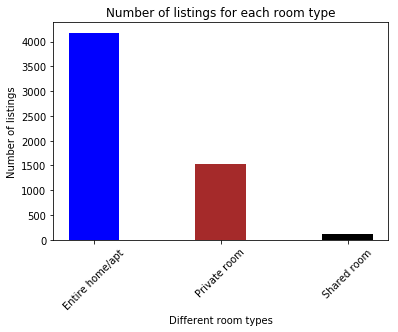

In [339]:
roomtypecount=updated_listings.groupby('room_type')['listing_id'].count().reset_index(name='count')
print(roomtypecount)
plt.bar(roomtypecount.iloc[:,0],roomtypecount.iloc[:,1],color=['blue','brown','black'],width=0.4)
plt.xlabel('Different room types')
plt.ylabel('Number of listings')
plt.title('Number of listings for each room type')
plt.xticks(rotation=45)
plt.show()

From the above analysis, we see that 'Entire Home/Apt' category dominates the total listings in Seattle area whereas there are only a few Shared room listings. 

__2. How many properties are listed for each room type in each neighbourhood?__

    neighbourhood_group  Number_of_listings
11  Other neighborhoods                 810
6              Downtown                 647
2          Capitol Hill                 472
4          Central Area                 448
12           Queen Anne                 344
0               Ballard                 262
16         West Seattle                 233
3               Cascade                 191
13       Rainier Valley                 190
1           Beacon Hill                 132
15  University District                 107
10            Northgate                  82
9              Magnolia                  79
5              Delridge                  73
8             Lake City                  58
14          Seward Park                  45
7              Interbay                   7


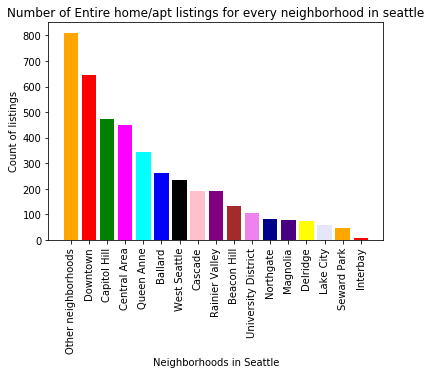

In [340]:
Entirehome = updated_listings[['neighbourhood_group','listing_id']].loc[updated_listings['room_type']=='Entire home/apt']
counts=Entirehome.groupby(['neighbourhood_group'],as_index=False).count().sort_values(by='listing_id',ascending=False)
counts.rename(columns={'listing_id':'Number_of_listings'},inplace=True)
print(counts)
plt.bar(counts.iloc[:,0],counts.iloc[:,1],color=['orange','red','green','magenta','cyan','blue','black','pink','purple','brown','violet','darkblue','indigo','yellow','lavender'])
plt.xlabel('Neighborhoods in Seattle')
plt.ylabel('Count of listings')
plt.title('Number of Entire home/apt listings for every neighborhood in seattle')
plt.xticks(rotation=90)
plt.show()

    neighbourhood_group  Number_of_listings
11  Other neighborhoods                 340
4          Central Area                 197
2          Capitol Hill                 178
13       Rainier Valley                 120
5              Delridge                 110
1           Beacon Hill                  84
10            Northgate                  74
12           Queen Anne                  73
0               Ballard                  65
16         West Seattle                  64
15  University District                  60
8             Lake City                  52
6              Downtown                  37
9              Magnolia                  32
3               Cascade                  17
14          Seward Park                  16
7              Interbay                   2


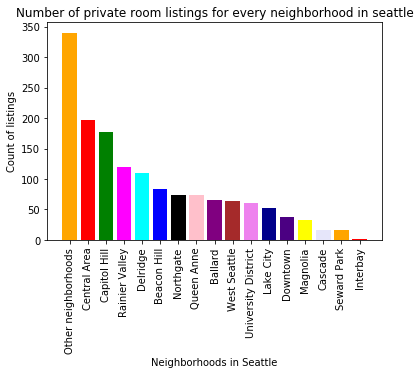

In [341]:
privateroom = updated_listings[['neighbourhood_group','listing_id']].loc[updated_listings['room_type']=='Private room']
counts=privateroom.groupby(['neighbourhood_group'],as_index=False).count().sort_values(by='listing_id',ascending=False)
counts.rename(columns={'listing_id':'Number_of_listings'},inplace=True)
print(counts)
plt.bar(counts.iloc[:,0],counts.iloc[:,1],color=['orange','red','green','magenta','cyan','blue','black','pink','purple','brown','violet','darkblue','indigo','yellow','lavender'])
plt.xlabel('Neighborhoods in Seattle')
plt.ylabel('Count of listings')
plt.title('Number of private room listings for every neighborhood in seattle')
plt.xticks(rotation=90)
plt.show()

    neighbourhood_group  Number_of_listings
2          Capitol Hill                  44
8   Other neighborhoods                  20
5              Downtown                  18
11  University District                  15
9            Queen Anne                   5
0               Ballard                   2
1           Beacon Hill                   1
3          Central Area                   1
4              Delridge                   1
6              Interbay                   1
7             Lake City                   1
10       Rainier Valley                   1


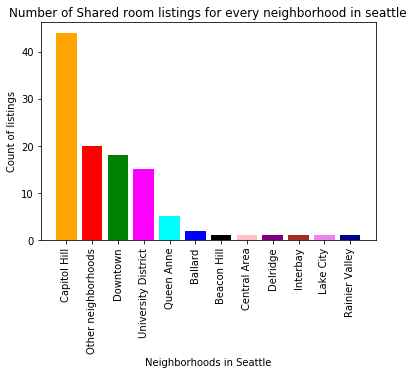

In [342]:
Sharedroom = updated_listings[['neighbourhood_group','listing_id']].loc[updated_listings['room_type']=='Shared room']
counts=Sharedroom.groupby(['neighbourhood_group'],as_index=False).count().sort_values(by='listing_id',ascending=False)
counts.rename(columns={'listing_id':'Number_of_listings'},inplace=True)
print(counts)
plt.bar(counts.iloc[:,0],counts.iloc[:,1],color=['orange','red','green','magenta','cyan','blue','black','pink','purple','brown','violet','darkblue','indigo','yellow','lavender'])
plt.xlabel('Neighborhoods in Seattle')
plt.ylabel('Count of listings')
plt.title('Number of Shared room listings for every neighborhood in seattle')
plt.xticks(rotation=90)
plt.show()

From the above three graphs, we can see that Downtown has the highest number of entire home/apt listings but significantly fewer private and shared room listings. We see significant number of listings in several smaller neighbourhoods grouped them together and termed as 'Other neighbourhoods'. This might be an indication that although they are not most popular places in Seattle, these places have demand as they offer privacy and free from vehicle sounds.

__3.What is the average price for different room types?__

         room_type  price
0  Entire home/apt  135.0
1     Private room   68.0
2      Shared room   42.3


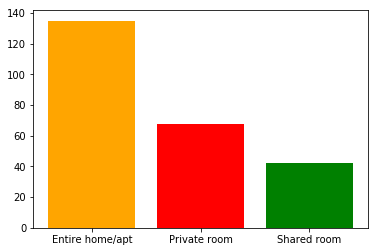

In [343]:
average_price=updated_listings[['room_type', 'price']].groupby(['room_type'], as_index=False).mean().sort_values(by='price',ascending=False)
print(average_price)
plt.bar(average_price.iloc[:,0],average_price.iloc[:,1],color=['orange','red','green'])
plt.show()

__4. What is the price distribution for each room type?__

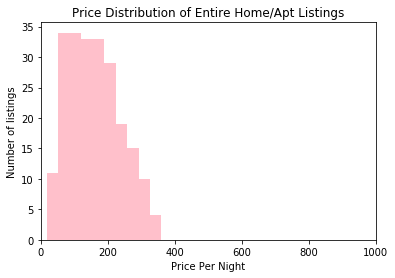

In [344]:
price_dist=updated_listings[['listing_id','price','room_type']].groupby(['price','room_type'],as_index=False).count().sort_values(by='price')
price_dist.rename(columns={'listing_id':'Number_of_listings'},inplace=True)
Entirehome=price_dist.loc[price_dist['room_type']=='Entire home/apt'].sort_values(by='Number_of_listings',ascending=False)
plt.hist(Entirehome.iloc[:,0],color='pink')
plt.xlabel('Price Per Night')
plt.ylabel("Number of listings")
plt.title('Price Distribution of Entire Home/Apt Listings')
plt.xlim(0,1000)
plt.show()

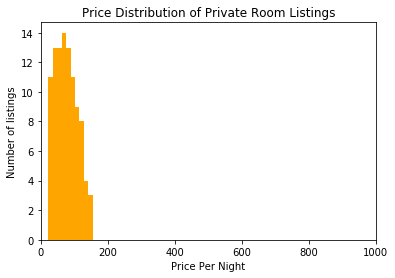

In [345]:
Privateroom=price_dist.loc[price_dist['room_type']=='Private room']
plt.hist(Privateroom.iloc[:,0],color='orange')
plt.xlabel('Price Per Night')
plt.ylabel("Number of listings")
plt.title('Price Distribution of Private Room Listings')
plt.xlim(0,1000)
plt.show()

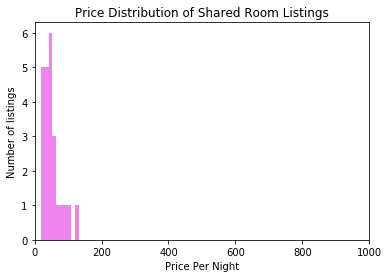

In [346]:
Sharedroom=price_dist.loc[price_dist['room_type']=='Shared room']
plt.hist(Sharedroom.iloc[:,0],color='violet')
plt.xlabel('Price Per Night')
plt.ylabel("Number of listings")
plt.title('Price Distribution of Shared Room Listings')
plt.xlim(0,1000)
plt.show()

From this analysis, we observe that majority of the Shared Rooms are within 50 price range whereas majority of the Private Rooms are within the price range of 100 and majority of Entire home/apt listings are within the price range of 300.

__5. What is the average price for each neighborhood?__

    neighbourhood_group  average_price
6              Downtown          170.3
12           Queen Anne          137.6
3               Cascade          129.7
4          Central Area          127.9
9              Magnolia          124.3
2          Capitol Hill          115.3
16         West Seattle          110.5
14          Seward Park          110.3
0               Ballard          107.1
11  Other neighborhoods          100.2
13       Rainier Valley           93.1
1           Beacon Hill           89.5
15  University District           84.8
10            Northgate           84.8
8             Lake City           78.5
7              Interbay           77.6
5              Delridge           69.9


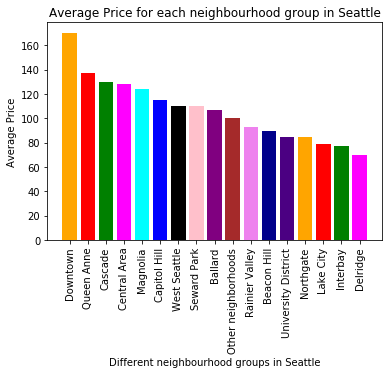

In [347]:
average_price=updated_listings[['neighbourhood_group', 'price']].groupby(['neighbourhood_group'], as_index=False).mean().sort_values(by='price',ascending=False)
average_price.rename(columns={'price':'average_price'},inplace=True)
print(average_price)
plt.bar(average_price.iloc[:,0],average_price.iloc[:,1],color=['orange','red','green','magenta','cyan','blue','black','pink','purple','brown','violet','darkblue','indigo'])
plt.xlabel('Different neighbourhood groups in Seattle')
plt.ylabel('Average Price')
plt.xticks(rotation=90)
plt.title('Average Price for each neighbourhood group in Seattle')
plt.show()

From the above analysis, we see that Downtown has highest average price and Delridge has least average price.

__6. What is the average price value for each room type in each neighbourhood?__

In [348]:
grouped_listings_mean=updated_listings.groupby(['neighbourhood_group','room_type'])['price'].mean().reset_index(name='average_price')
grouped_listings_mean
# grouped_listings_median=listings.groupby(['neighbourhood_group','room_type'])['price'].median().reset_index(name='median_price')
# print(grouped_listings_mean)
# print(grouped_listings_median)


,neighbourhood_group,room_type,average_price
0,Ballard,Entire home/apt,117.0
1,Ballard,Private room,67.8
2,Ballard,Shared room,84.5
3,Beacon Hill,Entire home/apt,108.7
4,Beacon Hill,Private room,59.9
5,Beacon Hill,Shared room,39.0
6,Capitol Hill,Entire home/apt,131.7
7,Capitol Hill,Private room,92.2
8,Capitol Hill,Shared room,32.6
9,Cascade,Entire home/apt,134.5


Visualization of the above results

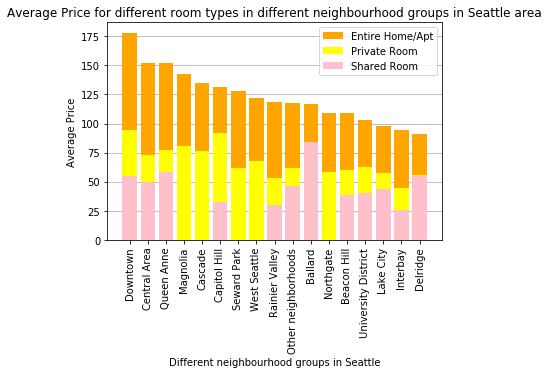

In [349]:
Entirehome=grouped_listings_mean.loc[grouped_listings_mean['room_type']=='Entire home/apt'].sort_values(by='average_price',ascending=False)
Privateroom=grouped_listings_mean.loc[grouped_listings_mean['room_type']=='Private room']
Sharedroom=grouped_listings_mean.loc[grouped_listings_mean['room_type']=='Shared room']
plt.bar(Entirehome.iloc[:,0],Entirehome.iloc[:,2],label='Entire Home/Apt',color='orange',zorder=2)
plt.bar(Privateroom.iloc[:,0],Privateroom.iloc[:,2],label='Private Room',color='yellow',zorder=2)
plt.bar(Sharedroom.iloc[:,0],Sharedroom.iloc[:,2],label='Shared Room',color='pink',zorder=2)
plt.legend()
plt.xticks(rotation=90)
plt.xlabel('Different neighbourhood groups in Seattle')
plt.ylabel('Average Price')
plt.title('Average Price for different room types in different neighbourhood groups in Seattle area')
plt.grid(axis='y')
plt.show()   #Ask for a better way to plot this info

From the above analysis, we see that average prices of the Shared Rooms are comparatively lesser than other room types in all areas except Ballard. Usually, the pricing trend is similar for all areas. Entire home/apt listings have high price followed by Private room which is followed by Shared room.

__7. What are the most popular neighbourhood groups in Seattle area?__

In [486]:
listings_2 = updated_listings.copy()
listings_2 = listings_2.assign(days_booked_365=listings_2['availability_365'].map(lambda x: 365-x))
popularity = listings_2.groupby('neighbourhood_group')['avg_reviews_per_month','days_booked_365'].mean().reset_index()
popularity = popularity.rename(columns={'avg_reviews_per_month':'neighbourhood_avg_monthly_reviews'
            ,'days_booked_365':'neighbourhood_days_booked_365'})
popularity.sort_values(['neighbourhood_avg_monthly_reviews','neighbourhood_days_booked_365'],ascending=False)

,neighbourhood_group,neighbourhood_avg_monthly_reviews,neighbourhood_days_booked_365
7,Interbay,3.4,288.2
1,Beacon Hill,3.2,237.7
2,Capitol Hill,3.2,221.5
4,Central Area,3.2,251.7
12,Queen Anne,3.1,228.0
0,Ballard,3.0,234.8
16,West Seattle,3.0,206.2
5,Delridge,3.0,221.7
13,Rainier Valley,2.9,221.8
11,Other neighborhoods,2.7,221.5


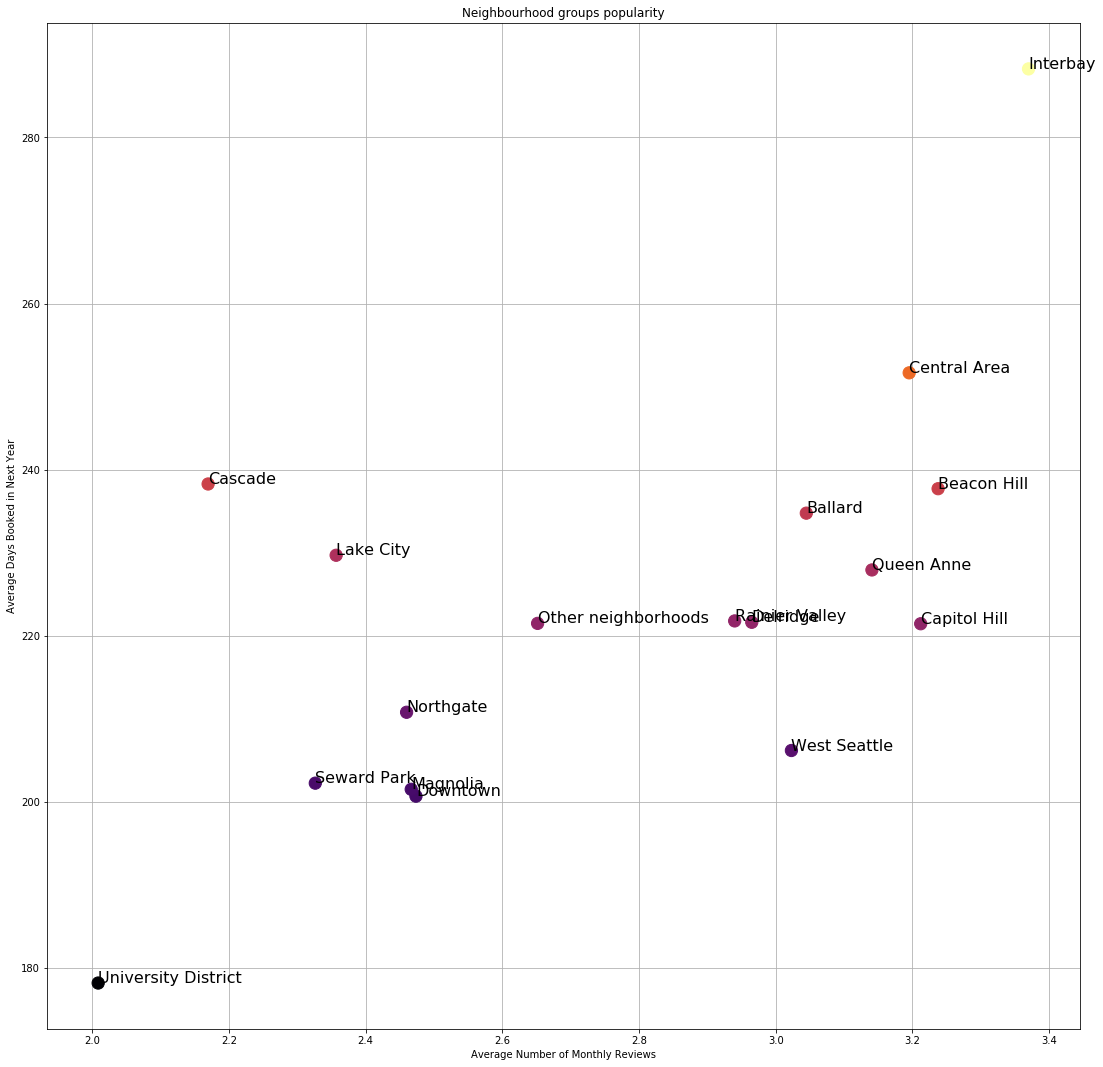

In [487]:
#Plot popularity of neighborhood groups
popularity.set_index('neighbourhood_group',inplace=True)
x = popularity.loc[:,'neighbourhood_avg_monthly_reviews']
y = popularity.loc[:,'neighbourhood_days_booked_365']
n = (popularity.index.tolist())

fig, ax = plt.subplots()
fig.set_size_inches(18.5, 18.5)
ax.scatter(x, y, c=y, cmap='inferno', s =150,zorder=2)

plt.xlabel('Average Number of Monthly Reviews')
plt.ylabel('Average Days Booked in Next Year')
plt.title('Neighbourhood groups popularity')

for i, txt in enumerate(n):
    ax.annotate(txt, (x[i],y[i]), fontsize = 16)

plt.grid()    
plt.show()

From this analysis, we see that Interbay is the most popular area followed by Beacon Hill,Central Area, Capitol Hill etc. Intrestingly, the top 10 popular neighbourhood groups are the groups with lesser average prices. This might be an indication that people are booking the places with lesser price rather than easily accessible places. However, University District is the least popular one and it is also the neighbourhood with less average prices. This might be because of the fact that students live in University District and they choose less expensive places to stay like motels rather than airbnb. 

__8. What is the trend of advanced booking for next year?__

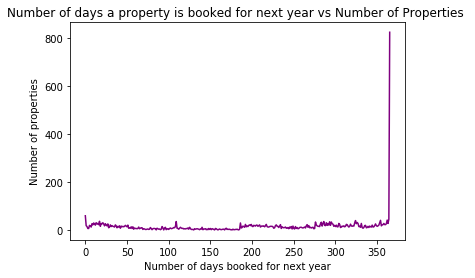

In [352]:
booked_days=listings_2[['listing_id','days_booked_365']].groupby('days_booked_365').count().reset_index()
plt.plot(booked_days['days_booked_365'],booked_days['listing_id'],color='purple')
plt.xlabel('Number of days booked for next year')
plt.ylabel('Number of properties')
plt.title('Number of days a property is booked for next year vs Number of Properties ')
plt.show()


We see that most of the properties are already booked for the entire year. But let's zoom in to see the trend in a better way

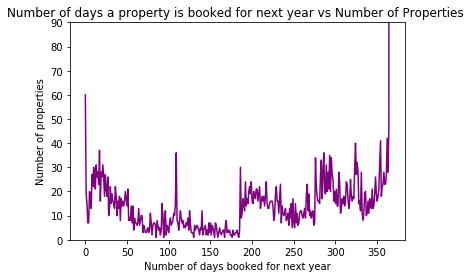

In [353]:
plt.plot(booked_days['days_booked_365'],booked_days['listing_id'],color='purple')
plt.xlabel('Number of days booked for next year')
plt.ylabel('Number of properties')
plt.title('Number of days a property is booked for next year vs Number of Properties ')
plt.ylim(0,90)
plt.show()

__9. What is the advance booking trend for each neighbourhood for each room type?__

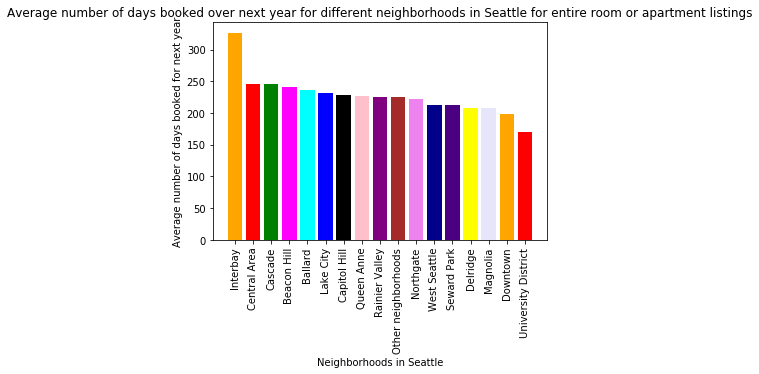

In [354]:
Entirehome = listings_2.loc[listings_2['room_type']=='Entire home/apt']
neighborhoods=Entirehome[['neighbourhood_group','days_booked_365']].groupby(['neighbourhood_group'],as_index=False)['days_booked_365'].mean().sort_values(by='days_booked_365',ascending=False)
plt.bar(neighborhoods.iloc[:,0],neighborhoods.iloc[:,1],color=['orange','red','green','magenta','cyan','blue','black','pink','purple','brown','violet','darkblue','indigo','yellow','lavender'])
plt.xlabel('Neighborhoods in Seattle')
plt.ylabel('Average number of days booked for next year')
plt.title('Average number of days booked over next year for different neighborhoods in Seattle for entire room or apartment listings')
plt.xticks(rotation=90)
plt.show()

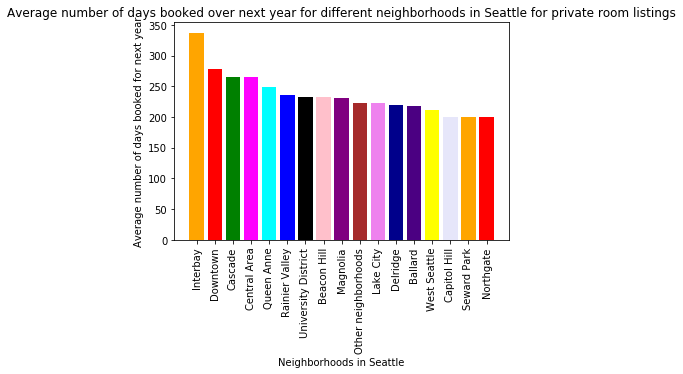

In [355]:
Privateroom = listings_2.loc[listings_2['room_type']=='Private room']
neighborhoods=Privateroom[['neighbourhood_group','days_booked_365']].groupby(['neighbourhood_group'],as_index=False)['days_booked_365'].mean().sort_values(by='days_booked_365',ascending=False)
plt.bar(neighborhoods.iloc[:,0],neighborhoods.iloc[:,1],color=['orange','red','green','magenta','cyan','blue','black','pink','purple','brown','violet','darkblue','indigo','yellow','lavender'])
plt.xlabel('Neighborhoods in Seattle')
plt.ylabel('Average number of days booked for next year')
plt.title('Average number of days booked over next year for different neighborhoods in Seattle for private room listings')
plt.xticks(rotation=90)
plt.show()

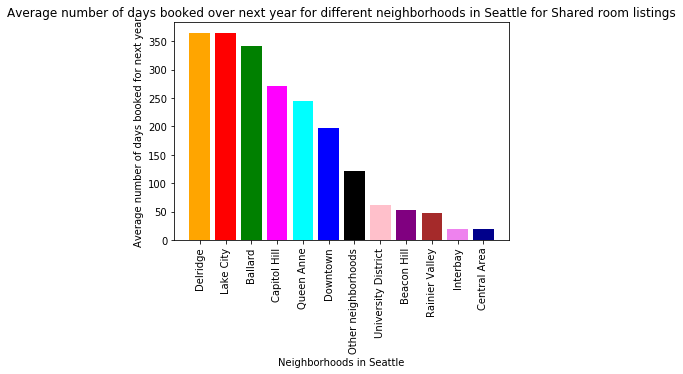

In [356]:
Sharedroom = listings_2.loc[listings_2['room_type']=='Shared room']
neighborhoods=Sharedroom[['neighbourhood_group','days_booked_365']].groupby(['neighbourhood_group'],as_index=False)['days_booked_365'].mean().sort_values(by='days_booked_365',ascending=False)
plt.bar(neighborhoods.iloc[:,0],neighborhoods.iloc[:,1],color=['orange','red','green','magenta','cyan','blue','black','pink','purple','brown','violet','darkblue','indigo','yellow','lavender'])
plt.xlabel('Neighborhoods in Seattle')
plt.ylabel('Average number of days booked for next year')
plt.title('Average number of days booked over next year for different neighborhoods in Seattle for Shared room listings')
plt.xticks(rotation=90)
plt.show()

From the above trends, we observe that certain areas have huge demand while a few areas are not in much demand. This provides a hint to the potential airbnb property owners in future on in which location they should list their property to gain profits.

In [357]:
neighbourhoods = listings_2[['neighbourhood_group','room_type','days_booked_365']].groupby(['neighbourhood_group','room_type'])['days_booked_365'].mean().reset_index(name='average_days_booked_365')
neighbourhoods

,neighbourhood_group,room_type,average_days_booked_365
0,Ballard,Entire home/apt,236.7
1,Ballard,Private room,218.7
2,Ballard,Shared room,341.5
3,Beacon Hill,Entire home/apt,241.0
4,Beacon Hill,Private room,231.8
5,Beacon Hill,Shared room,53.0
6,Capitol Hill,Entire home/apt,228.3
7,Capitol Hill,Private room,199.8
8,Capitol Hill,Shared room,272.0
9,Cascade,Entire home/apt,245.4


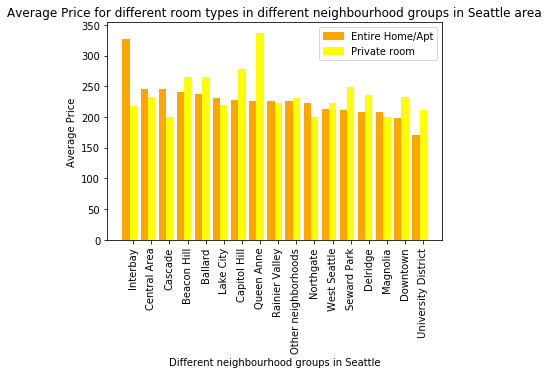

In [358]:
Entirehome=neighbourhoods.loc[neighbourhoods['room_type']=='Entire home/apt'].sort_values(by='average_days_booked_365',ascending=False)
Privateroom=neighbourhoods.loc[neighbourhoods['room_type']=='Private room']
Sharedroom=neighbourhoods.loc[neighbourhoods['room_type']=='Shared room']
# plt.bar(Entirehome.iloc[:,0],Entirehome.iloc[:,2],label='Entire Home/Apt',color='orange')
# plt.bar(Privateroom.iloc[:,0],Privateroom.iloc[:,2],label='Private Room',color='yellow')
# plt.bar(Sharedroom.iloc[:,0],Sharedroom.iloc[:,2],label='Shared Room',color='pink')
# plt.legend()
# plt.xticks(rotation=90)
# plt.xlabel('Different neighbourhood groups in Seattle')
# plt.ylabel('Average Price')
# plt.title('Average Price for different room types in different neighbourhood groups in Seattle area')
# plt.show()
#Ask for a better way to plot this info
x=np.arange(len(Entirehome.index))
y1=Entirehome.iloc[:,2].values
y2=Privateroom.iloc[:,2].values
# y3=Sharedroom.iloc[:,2].values
bar_width=0.4
plt.bar(x,y1,width=bar_width,color='orange',zorder=2)
plt.bar(x+bar_width,y2,width=bar_width,color='yellow',zorder=2)
# plt.bar(x+bar_width*2,y3,width=bar_width,color='pink',zorder=2)

plt.xticks(x+bar_width,Entirehome.iloc[:,0].values,rotation=90)
plt.xlabel('Different neighbourhood groups in Seattle')
plt.ylabel('Average Price')
plt.title('Average Price for different room types in different neighbourhood groups in Seattle area')

orange_patch=mpatches.Patch(color='orange',label='Entire Home/Apt')
yellow_patch=mpatches.Patch(color='yellow',label='Private room')

plt.legend(handles=[orange_patch,yellow_patch])

plt.show()



__Price Prediction__

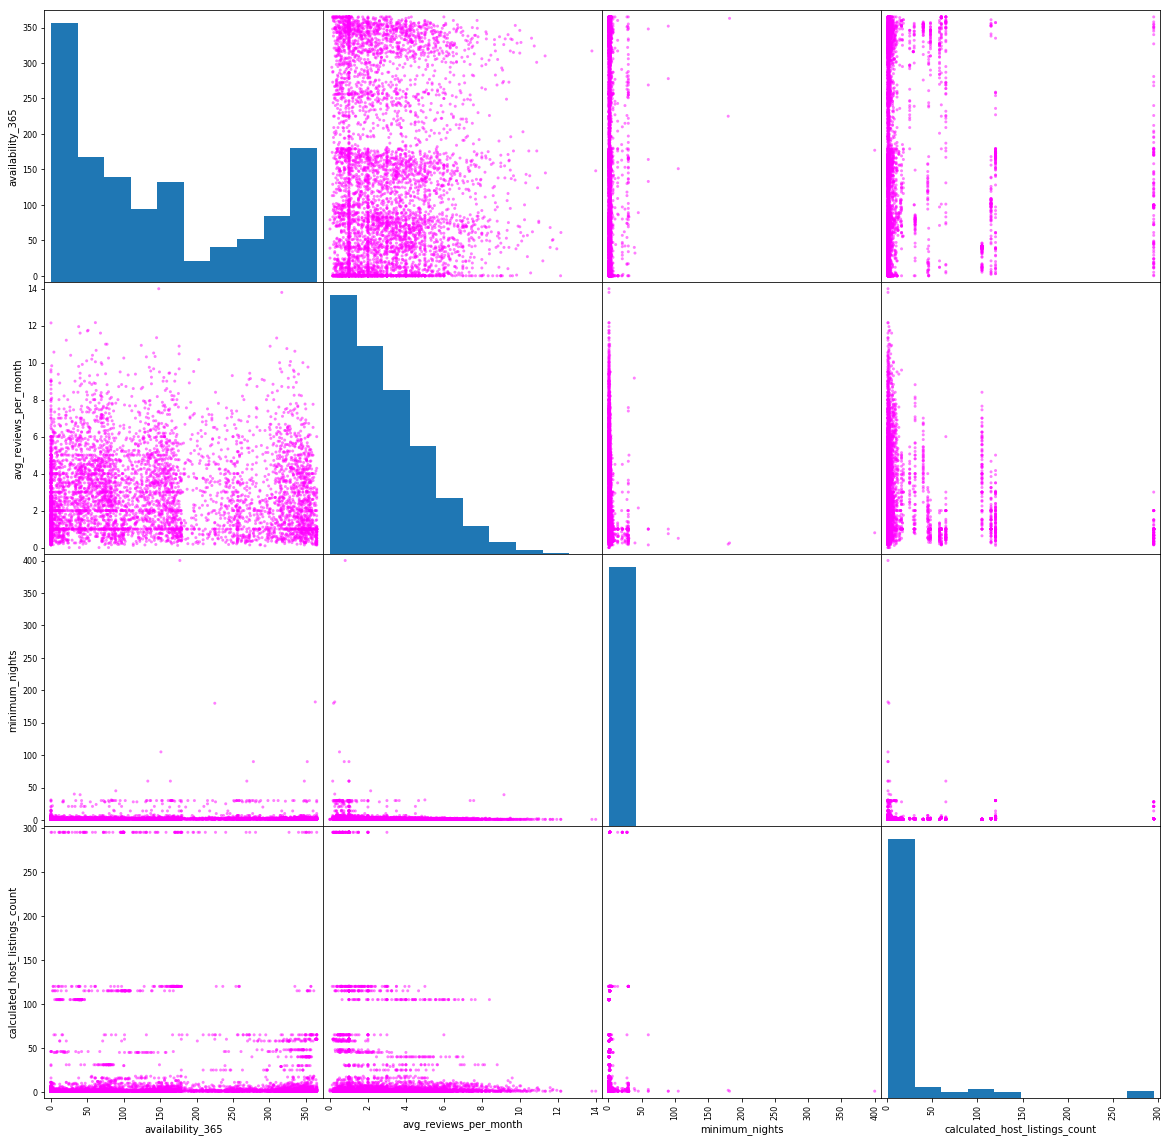

In [359]:
# check for collinearity and visualize relationship between each predictor and price
updated_listings=updated_listings.fillna(0)
updated_listings['log_price']=np.log(updated_listings['price'])
matrix_cols = ['availability_365', 'avg_reviews_per_month','minimum_nights','calculated_host_listings_count']
axs = pd.plotting.scatter_matrix(updated_listings[matrix_cols], figsize=(20, 20), c='magenta')

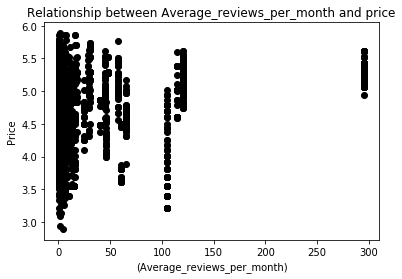

In [360]:
plt.xlabel('(Average_reviews_per_month)')
plt.ylabel('Price')
plt.title('Relationship between Average_reviews_per_month and price')
plt.scatter(updated_listings['calculated_host_listings_count'],updated_listings['log_price'],color='black')
plt.show()

In [493]:
updated_listings=updated_listings.fillna(0)
updated_listings['log_price']=np.log(updated_listings['price'])
# updated_listings.drop(columns='number_of_reviews',inplace=True)
X=updated_listings.loc[:,['neighbourhood_group','room_type','availability_365','avg_reviews_per_month']].values
y=updated_listings.loc[:,'log_price'].values
y=y.reshape(-1,1)

In [494]:
#Encoding the categorical variables
labelencoder = LabelEncoder()
X[:,0]=labelencoder.fit_transform(X[:,0])
X[:,1]=labelencoder.fit_transform(X[:,1])

onehotencoder = OneHotEncoder(categorical_features=[0,1])
X=onehotencoder.fit_transform(X).toarray()

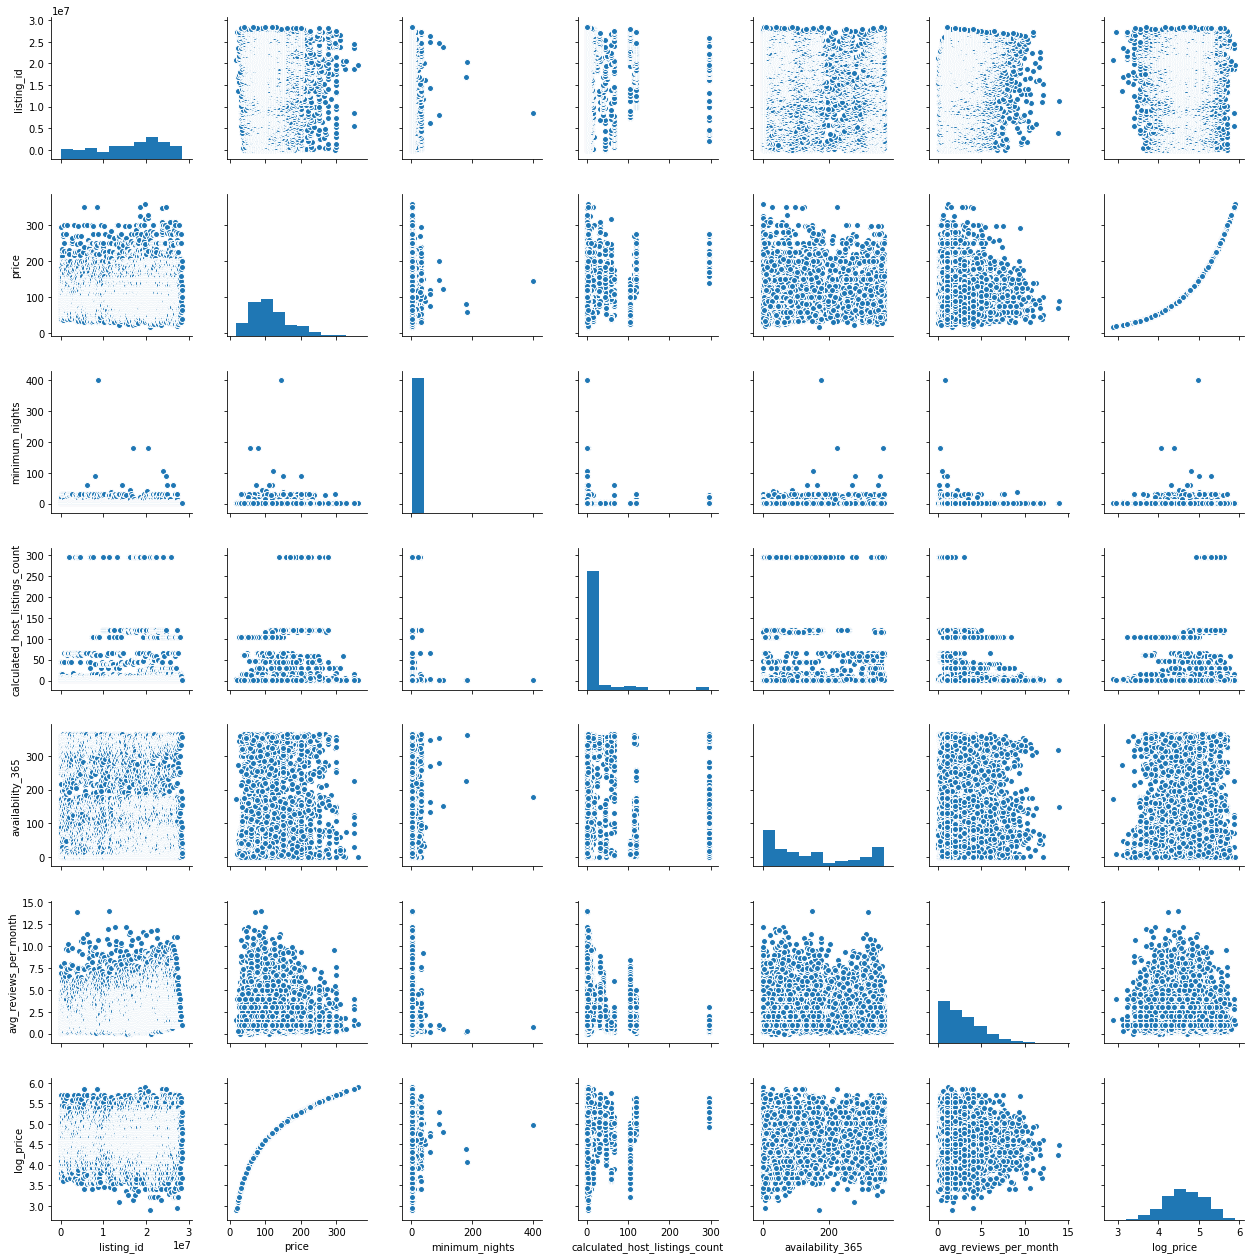

In [364]:
sns.pairplot(updated_listings)

C:\Users\Harish\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


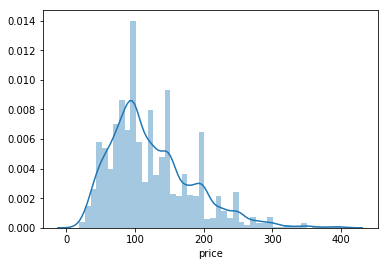

In [323]:
sns.distplot(updated_listings['price'])

In [383]:
(updated_listings.corr().round(4))

,listing_id,price,minimum_nights,calculated_host_listings_count,availability_365,avg_reviews_per_month,log_price
listing_id,1.0,0.1,-0.1,0.1,-0.2,0.1,0.0
price,0.1,1.0,0.0,0.3,0.1,-0.1,1.0
minimum_nights,-0.1,0.0,1.0,0.0,0.0,-0.1,0.0
calculated_host_listings_count,0.1,0.3,0.0,1.0,0.0,-0.2,0.2
availability_365,-0.2,0.1,0.0,0.0,1.0,-0.0,0.1
avg_reviews_per_month,0.1,-0.1,-0.1,-0.2,-0.0,1.0,-0.1
log_price,0.0,1.0,0.0,0.2,0.1,-0.1,1.0


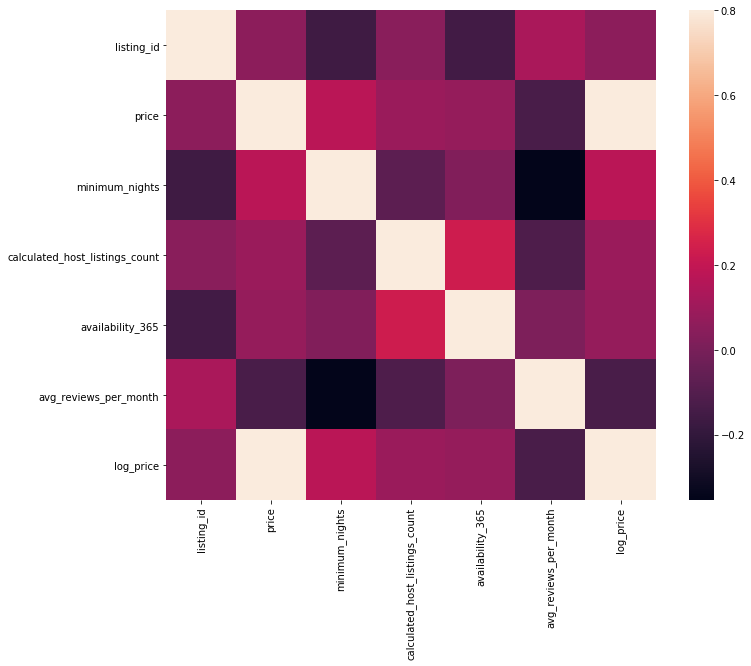

In [365]:
# sns.pairplot(updated_listings, x_vars=['availability_365','avg_reviews_per_month'], y_vars='log_price', size=7, aspect=0.7,kind='reg')
corrmat=updated_listings.corr(method='spearman')
# updated_listings.corr()

# plt.matshow(updated_listings.corr())
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

In [495]:
X=X[:,1:]
# X=X[:,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20]]
X=np.delete(X,np.s_[16],axis=1)
print(X.shape)
# import os
# path_d = '/Users/Harish/Desktop'
# popularity.to_csv(os.path.join(path_d, 'popularity.csv'))
# updated_listings.to_csv(os.path.join(path_d, 'updated_listings.csv'))
# updated_reviews.to_csv(os.path.join(path_d, 'updated_reviews.csv'))

(5544, 20)


In [496]:
#Feature Scaling. Only required for SVR model as it doesn't have inbuilt feature scaling
sc_X = StandardScaler()
# X_train = sc_X.fit_transform(X_train)
# X_test = sc_X.transform(X_test)
sc_y = StandardScaler()
# y_train = sc_y.fit_transform(y_train)

In [420]:
#Splitting the training and test sets in 80:20 ratio


#Applying linear regression
rmse=[]
avgrmse = 0
intercept=[]
coeff=[]
for i in range(10):
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)
#     X_train = sc_X.fit_transform(X_train)
#     X_test = sc_X.transform(X_test)
#     y_train = sc_y.fit_transform(y_train)
    regressor=LinearRegression(fit_intercept=True,normalize=True)
    regressor.fit(X_train,y_train)
    y_pred=regressor.predict(X_test)
#     y_pred=sc_y.inverse_transform(y_pred)
    mse=metrics.mean_squared_error(y_test,y_pred)
    rmse.append(np.sqrt(mse))
    avgrmse = avgrmse + rmse[i]
    intercept.append(regressor.intercept_)
    coeff.append(regressor.coef_)
print(avgrmse/10)
print(sum(intercept)/len(intercept))
print(sum(coeff)/len(coeff))
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(LinearRegression(), X, y, cv=5, scoring='r2')
print(scores)

0.25355298569551
5.00182298243425
[-5.75649195e-02  1.47247976e-01  1.40078128e-01 -2.08578716e-02
 -1.95843696e-01  3.31992059e-01 -2.85980793e-01 -2.01564019e-01
  1.83433306e-01 -1.67216789e-01 -4.64676224e-02  1.67188132e-01
 -1.38918285e-01 -2.74419930e-02 -2.28555512e-01  8.77079208e-02
 -6.72692829e-01 -1.27006944e+00  7.32741075e-05 -1.98312947e-02]
[0.74351493 0.66669579 0.67322022 0.72999251 0.72718276]


In [479]:
#Applying Lasso
rmse=[]
avgrmse=0
for i in range(10):
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)
    regressor=Lasso(alpha=0.0001,fit_intercept=True,random_state=0,normalize=True,max_iter=10000)
    regressor.fit(X_train,y_train)
    y_pred=regressor.predict(X_test)
    mse=metrics.mean_squared_error(y_test,y_pred)
    rmse.append(np.sqrt(mse))
    avgrmse = avgrmse + rmse[i]
print(avgrmse/10)

0.2615788436432436


In [455]:
#Applying Ridge
rmse=[]
avgrmse=0
for i in range(10):
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)
    regressor=Ridge(alpha=1.0,fit_intercept=True,random_state=0)
    regressor.fit(X_train,y_train)
    y_pred=regressor.predict(X_test)
    mse=metrics.mean_squared_error(y_test,y_pred)
    rmse.append(np.sqrt(mse))
    avgrmse = avgrmse + rmse[i]
print(avgrmse/10)

0.4123534409061572


In [501]:
#Applying RandomForest Regressor model to our dataset
rmse=[]
avgrmse=0
for i in range(10):
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)
    regressor=RandomForestRegressor(n_estimators=100,criterion='mse',n_jobs=-1)
    regressor.fit(X_train,y_train)
    y_pred=regressor.predict(X_test)
    mse=metrics.mean_squared_error(y_test,y_pred)
    rmse.append(np.sqrt(mse))
    avgrmse = avgrmse + rmse[i]
print(avgrmse/10)
X_train=pd.DataFrame(X_train)
print(sorted(zip(map(lambda x: round(x, 4), regressor.feature_importances_),X_train.columns), 
             reverse=True))
print(X_train)
regressor.score(X_test,y_test)

C:\Users\Harish\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys
C:\Users\Harish\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys
C:\Users\Harish\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys
C:\Users\Harish\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys
C:\Users\Harish\Anaconda3\lib\site-packages\ipykerne

0.32869444004133974
[(0.3778, 16), (0.1716, 18), (0.17, 19), (0.1278, 17), (0.0533, 5), (0.0241, 1), (0.0106, 11), (0.0104, 3), (0.0075, 10), (0.0064, 14), (0.0059, 12), (0.0052, 15), (0.005, 2), (0.0048, 7), (0.0048, 4), (0.0044, 8), (0.0034, 9), (0.0031, 13), (0.0031, 0), (0.0007, 6)]
      0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  17  \
0    0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0   
1    0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0   
2    0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0   
3    0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
4    0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0   
5    0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0   
6    0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0   
7    0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0

0.5445268529658299

In [500]:
#Applying SVR algorithm to our dataset
rmse=[]
avgrmse=0
for i in range(10):
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)
    X_train = sc_X.fit_transform(X_train)
    X_test = sc_X.transform(X_test)
    y_train = sc_y.fit_transform(y_train)
    regressor = SVR(kernel = 'sigmoid')
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    y_pred = sc_y.inverse_transform(y_pred)
    mse=metrics.mean_squared_error(y_test,y_pred)
    rmse.append(np.sqrt(mse))
    avgrmse = avgrmse + rmse[i]
print(avgrmse/10)

C:\Users\Harish\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Harish\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Harish\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Harish\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

2.4652067513130045


In [372]:
#K-fold cross validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = regressor, X = X_train, y = y_train, cv = 5,n_jobs=-1)
print(accuracies)
print(accuracies.mean()) #Prints the percentage accuracy of the machine learning model
print(accuracies.std()) #prints the standard deviation of the machine learning model

[0.58929469 0.56395221 0.54432814 0.55752112 0.57128169]
0.5652755703228756
0.01492426989292901


In [197]:
#mse and rmse results


mse=metrics.mean_squared_error(y_test,y_pred)
rmse=(np.sqrt(mse))
print(rmse)



[0.3110024447190108, 0.3110024447190108, 0.3110024447190108, 0.3110024447190108, 0.3110024447190108, 0.3110024447190108]
[0.3110024447190108, 0.3110024447190108, 0.3110024447190108, 0.3110024447190108, 0.3110024447190108, 0.3110024447190108]


In [ ]:
import statsmodels.formula.api as sm
X=np.append(arr=np.ones((5544,1)).astype(int),values=X,axis=1)
x_opt=X
regressor_OLS=sm.OLS(endog=y,exog=x_opt).fit()
regressor_OLS.summary()